In [203]:
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import random as rnd
%matplotlib inline

In [204]:
G = nx.read_edgelist("ChCh-Miner_durgbank-chem-chem.tsv") # Our dataset is stored as an edge list, we use networkx to read the file into a Graph object

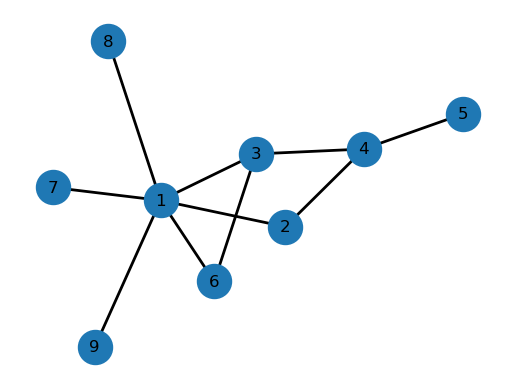

In [237]:
Go = nx.Graph([(1,2),(1,3),(1,6),(1,7),(1,8),(1,9),(3,4),(3,6),(4,5),(4,2)]) # observed graph Go

nx.draw_networkx(Go,with_labels=True,node_size=600,width=2) # draw it pretty
limits=plt.axis('off')                                      # turn off axes
plt.show() 

In [245]:

def katzAlg(G, cutoff, i,j):
    paths = nx.all_simple_paths(G, source=i, target=j, cutoff=cutoff)
    score = 0
    for x in paths:
        score = score + (1/(len(x)))
    return score
    
katzAlg(Go, 6, 1,4)

[1, 2, 4]
[1, 3, 4]
[1, 6, 3, 4]


0.9166666666666666

In [193]:
def randomwalk_DistributionGen(G,walkLen): # Will find a distribution of the frequency of walks on certain nodes
    
    walkPaths = [] # store current path so no duplicates
    distribution = {} # store distrutions
    nodes = []

    for node in G.nodes(): #Initialize Distributions/Nodes
        distribution[node] = 0
        nodes.append(node)
    for nodeC in nodes: #Random walk
        node = nodeC
        steps = 0
        walkPath = []
        while (steps < walkLen): #Start walking
            neighbors = G.neighbors(node) #Get neighbors of current node
            walkPath.append(node) #Add current node to the walk path
            neighbors = list(set(neighbors) - set(walkPath)) #Remove all neighbors that have been walked through
            if len(neighbors) == 0: #If there are no elegible neighbors, we break
                break 
            steps+=1 #increase step count
            node = rnd.choice(neighbors) #Choose a random neighbor to walk from for the next loop
            distribution[node]+=1 #Increase distrubtions
        walkPaths.append(walkPath)    #log every walk path for testing
    
    return distribution


In [194]:
print(dist)
print(randomwalk_DistributionGen(Go,5)[1])
print(randomwalk_DistributionGen(Go,5)[4])
print(predictor_randomwalk(Go,1,4))

{0: 0.0002687088539567379, 1: 0.00040306328093510683, 2: 0.0006717721348918447, 3: 0.0013435442697836894, 4: 0.002149670831653903, 5: 0.0014778986967620583, 6: 0.0008061265618702137, 7: 0.0024183796856106408, 8: 0.0017466075507187962, 9: 0.00040306328093510683, 10: 0.0002687088539567379, 11: 0.0018809619776971652, 12: 0.0014778986967620583, 13: 0.004299341663307806, 14: 0.0010748354158269515, 15: 0.004433696090286175, 16: 0.0013435442697836894, 17: 0.0005374177079134758, 18: 0.0014778986967620583, 19: 0.0024183796856106408, 20: 0.0009404809888485826, 21: 0.0017466075507187962, 22: 0.0005374177079134758, 23: 0.0016122531237404273, 24: 0.002149670831653903, 25: 0.0016122531237404273, 26: 0.0030901518205024856, 27: 0.0013435442697836894, 28: 0.0008061265618702137, 29: 0.0012091898428053204, 30: 0.002284025258632272, 31: 0.0010748354158269515, 32: 0.0037619239553943304, 33: 0.002687088539567379, 34: 0.0002687088539567379, 35: 0.00040306328093510683, 36: 0.002284025258632272, 37: 0.00349321

In [246]:
def predictor_Baseline(): # Our baseline predictor, taken from the PS5 solutions
    return rnd.random()

def predictor_Jaccard(Gx,i,j): # Our Jaccard predictor, taken from the PS5 solutions
    j_temp = nx.jaccard_coefficient(Gx, [(i,j)])
    for u,v,p in j_temp:
        jaccard = p
    n = Gx.order()
    return jaccard + rnd.uniform(0,1/(10*n))

def predictor_DegreeProd(Gx,i,j): # Our Jaccard predictor, taken from the PS5 solutions
    d_temp = nx.preferential_attachment(Gx, [(i,j)])
    for u,v,p in d_temp:
        degreeprod = p
    n = Gx.order()
    return degreeprod + rnd.uniform(0,1/(10*n))

def predictor_Katz(Gx,cutoff,i,j): # Our Katz predictor, created by us
    paths = nx.all_simple_paths(Gx, source=i, target=j, cutoff=cutoff)
    score = sum(1/len(x) for x in paths)
    n = Gx.order()     
    return score + rnd.uniform(0,1/(10*n))

def predictor_randomwalk(Gx,i,j): # Our RandomWalk predictor, created by us
    distribution = dist
    n = Gx.order()
    return distribution[i] * distribution[j] + rnd.uniform(0,1/(10*n))

def get_candidateEdges(G): # This function returns all the non edges in graph G
    nonEdges = list(nx.non_edges(G))
    return nonEdges

def apply_Predictors(G, Y): # This functions stores the results from all of our predictors in an np array 
    Y2 = get_candidateEdges(G) # First, we get the edges that we want our predictors to make a prediction on
    table = np.ndarray((len(Y2), 8), dtype = object) # Here, we are creating the np array to store all of our results beforehand, this is done to speed up program runtime
    table[:,0] = int(len(Y2)) # We make sure to cast the int type to the first two columns
    table[:,1] = int(len(Y2)) # These first two columns will store the nodes within the edge, we need them in int form in order to check if they are in the missing edge list
    table[:,2] = int(len(Y2)) # We cast the third column to int because this will store the tau values, 0 = False and 1 = True
    table[:,3:] = float(len(Y2)) # The rest of the columns are casted to float format because they will contain the results of our predictors
    counter = 0 # This counter will be used to add an entry to the closest vacant spot in our np array

    for link in Y2: # We iterate through the candidate edges, having our predictors make an estimation on the liklihood of an edge being a real missing edge 
        if(link[0], link[1]) in Y: # We check if the candidate edge is a true missing edge 
            tau = 1
        else:
            tau = 0 # If the candidate edge is not within the missing edge list, then tau = 0
        baseline = float(predictor_Baseline()) # We make sure to cast the results of our predictors to floats
        jaccard = float(predictor_Jaccard(G, link[0], link[1])) # We do this because the output of the predictors are initially strings, which do not work within a homogenous np array
        degreeProd = float(predictor_DegreeProd(G, link[0], link[1]))
        randomWalk = float(predictor_randomwalk(G, link[0], link[1]))
        katz = float(predictor_Katz(G, 2, link[0], link[1]))
        
        table[counter,:] = [link[0], link[1], tau, baseline, jaccard, degreeProd, randomWalk, katz] # Here we are adding an entry to the np array in the closest vacant spot
        counter += 1 # Increment counter to the index of the closest vacant spot

    return table

In [228]:
def generateGo(G, alpha): # This function creates the observed graph from the original graph
    Go = G.copy() # We first make a copy of the original graph
    mapping = {old_label:new_label for new_label, old_label in enumerate(Go.nodes())} # The nodes in this graph are in this form: XX00000, this code is modified from stackoverflow
    Go = nx.relabel_nodes(Go, mapping) # We relabel the node names into integers because np arrays are homogenous data structures and cannot contain strings and numbers 
    missingEdges = [] # This list will contain all the missing edges which remove from Go
    randomNum = 0
    
    for edge in Go.edges(): # We iterate through the edges of Go
        randomNum = np.random.uniform(0, 1) # We generate a random number between 0 and 1
        if randomNum > alpha: # We use alpha where 0 < alpha < 1 to determine how many edges will be removed from the Go
            Go.remove_edge(edge[0], edge[1]) 
            missingEdges.append(edge) # We make sure to store the edge which was removed 
    
    return Go, missingEdges

In [229]:
def tabulate_TPR_FPR(S): # This code was used from our PS5
    tkTrue = 0
    tkFalse = 0
    TPR = []
    FPR = []
    T = 0
    F = 0
    
    for i in range(0, len(S)): # Iterate once through S in order to determine the normalizing constants
        if S[i][2] == 1:
            T += 1
        else:
            F += 1
            
    for j in range(0, len(S)): # Iterate again to calculate the TPR and FPR
        if(S[j][2]) == 1:
            tkTrue += 1
        else:
            tkFalse += 1
        TPR.append(tkTrue / T)
        FPR.append(tkFalse / F)
        
    columnOne = S[:, 0] # Here we are getting the columns of the table in the desired return format
    columnTwo = S[:, 1]
    columnThree = S[:, 2]
    columnFour = np.array(TPR)
    columnFive = np.array(FPR)
    columnSix = S[:, 3]

    columnOne = columnOne.reshape(len(columnOne), 1) # Reshaping columns, turning them into columns instead of horizontal lists
    columnTwo = columnTwo.reshape(len(columnTwo), 1)
    columnThree = columnThree.reshape(len(columnThree), 1)
    columnFour = columnFour.reshape(len(columnFour), 1)
    columnFive = columnFive.reshape(len(columnFive), 1)
    columnSix = columnSix.reshape(len(columnSix), 1)

    table = np.hstack((columnOne, columnTwo)) # Here we are combining those columns into the table in the desired return format
    table = np.hstack((table, columnThree))
    table = np.hstack((table, columnFour))
    table = np.hstack((table, columnFive))
    table = np.hstack((table, columnSix))
    return table    

def calculate_AUC(TPR,FPR):
    AUC = 0
    TPR = np.insert(TPR, 0, 0) # Prepend 0
    FPR = np.insert(FPR, 0, 0)
    for i in range(1, len(TPR)):
        AUC += TPR[i] * (FPR[i] - FPR[i - 1]) # calculate AUC according to lecture notes 4
    return AUC

In [11]:
import random as rnd
seed = 703
rnd.seed(seed)

nreps = 3 # This is the number of repetitions to perform for each value of alpha, we use this to get an average of the AUC for each predictor which reduces noise
alphas  = [.55, .65, .75, .85, .95] # Here are the values of alpha which we use in our missingness function 

AUCs_base = []
AUCs_degp = []
AUCs_jacc = []
AUCs_ranw.append = []
AUCs_katz.append = []

jaccardAUC = 0
baselineAUC = 0
degreeProdAUC = 0
randomWalkAUC = 0
katzAUC = 0

for alpha in alphas:
    for r in range(nreps):
        Go, missing = generateGo(G, alpha) # Generate the observed graph and missing edges
        dist = randomwalk_DistributionGen(Go,5) # Generate distrubtion for random walk. 

        table = apply_Predictors(Go, missing) # Apply the predictors for this observed graph at the current level of alpha

        columnOne = table[:, 0] # Here I am getting the columns of the table in the desired input format, this code was taken from our PS5 
        columnTwo = table[:, 1] # We use the columns to create tables in the format needed for the tabulate_TPR_FPR and calculate_AUC function
        columnThree = table[:, 2] # The first three columns are node i, node j, tau, in that order
        columnFour = table[:, 3] # This column contains the baseline predictions
        columnFive = table[:, 4] # This column contains the jaccard predictions
        columnSix = table[:, 5] # This column contains the degree product predictions
        columnSeven = table[:, 6] # This column contains the random walk predictions
        columnEight = table[:, 7] # This column contains the <insert> predictions

        columnOne = columnOne.reshape(len(columnOne), 1) # Reshaping columns, turning them into columns instead of horizontal lists
        columnTwo = columnTwo.reshape(len(columnTwo), 1)
        columnThree = columnThree.reshape(len(columnThree), 1)
        columnFour = columnFour.reshape(len(columnFour), 1)
        columnFive = columnFive.reshape(len(columnFive), 1)
        columnSix = columnSix.reshape(len(columnSix), 1)
        columnSeven = columnSeven.reshape(len(columnSeven), 1)
        columnEight = columnEight.reshape(len(columnEight), 1)

        baselineTable = np.hstack((columnOne, columnTwo)) # Here we are combining the columns of the table in the desired return format
        baselineTable = np.hstack((baselineTable, columnThree))
        baselineTable = np.hstack((baselineTable, columnFour))
        baselineTable = baselineTable[np.argsort(baselineTable[:, 3])[::-1]] # Here we are sorting the table by the score column in descending order

        jaccardTable = np.hstack((columnOne, columnTwo)) 
        jaccardTable = np.hstack((jaccardTable, columnThree)) 
        jaccardTable = np.hstack((jaccardTable, columnFive))
        jaccardTable = jaccardTable[np.argsort(jaccardTable[:, 3])[::-1]]

        degreeProductTable = np.hstack((columnOne, columnTwo)) 
        degreeProductTable = np.hstack((degreeProductTable, columnThree))
        degreeProductTable = np.hstack((degreeProductTable, columnSix))
        degreeProductTable = degreeProductTable[np.argsort(degreeProductTable[:, 3])[::-1]]

        randomWalkTable = np.hstack((columnOne, columnTwo)) 
        randomWalkTable = np.hstack((randomWalkTable, columnThree))
        randomWalkTable = np.hstack((randomWalkTable, columnSeven))
        randomWalkTable = randomWalkTable[np.argsort(randomWalkTable[:, 3])[::-1]]

        katzTable = np.hstack((columnOne, columnTwo)) 
        katzTable = np.hstack((katzTable, columnThree))
        katzTable = np.hstack((katzTable, columnEight))
        katzTable = katzTable[np.argsort(katzTable[:, 3])[::-1]]

        baselineTable = tabulate_TPR_FPR(baselineTable) # Here we are tabulating the tables and getting the TPR and FPR 
        jaccardTable = tabulate_TPR_FPR(jaccardTable)
        degreeProductTable = tabulate_TPR_FPR(degreeProductTable)
        randomWalkTable = tabulate_TPR_FPR(randomWalkTable)
        katzTable = tabulate_TPR_FPR(katzTable)

        baselineAUC += calculate_AUC(baselineTable[:, 3], baselineTable[:, 4]) # Once we have tabulated the tables, we get the AUC for each predictor
        jaccardAUC += calculate_AUC(jaccardTable[:, 3], jaccardTable[:, 4])
        degreeProdAUC += calculate_AUC(degreeProductTable[:, 3], degreeProductTable[:, 4])
        randomWalkAUC += calculate_AUC(randomWalkTable[:, 3], randomWalkTable[:, 4])
        katzAUC += calculate_AUC(katzTable[:, 3], katzTable[:, 4])
        
        baselineTable = [] # Here we reset the tables and columns, just to make sure everything is clean for the next iteration
        jaccardTable = []
        degreeProductTable = []
        randomWalkTable = []
        katzTable = []
        columnOne = []
        columnTwo = []
        columnThree = []
        columnFour = []
        columnFive = []
        columnSix = []
        columnSeven = []
        columnEight = []
        
    baselineAUC /= nreps # Here we get the average AUC for each predictor for the current value of alpha
    jaccardAUC /= nreps
    degreeProdAUC /= nreps
    randomWalkAUC /= nreps
    katzAUC /= nreps
    
    AUCs_base.append(baselineAUC)
    AUCs_degp.append(degreeProdAUC)
    AUCs_jacc.append(jaccardAUC)
    AUCs_ranw.append(randomWalkAUC)
    AUCs_katz.append(katzAUC)
    
    baselineAUC = 0 # We reset the AUC values here
    jaccardAUC = 0
    degreeProdAUC = 0
    randomWalkAUC = 0
    katzAUC = 0

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (5,) and (0,)

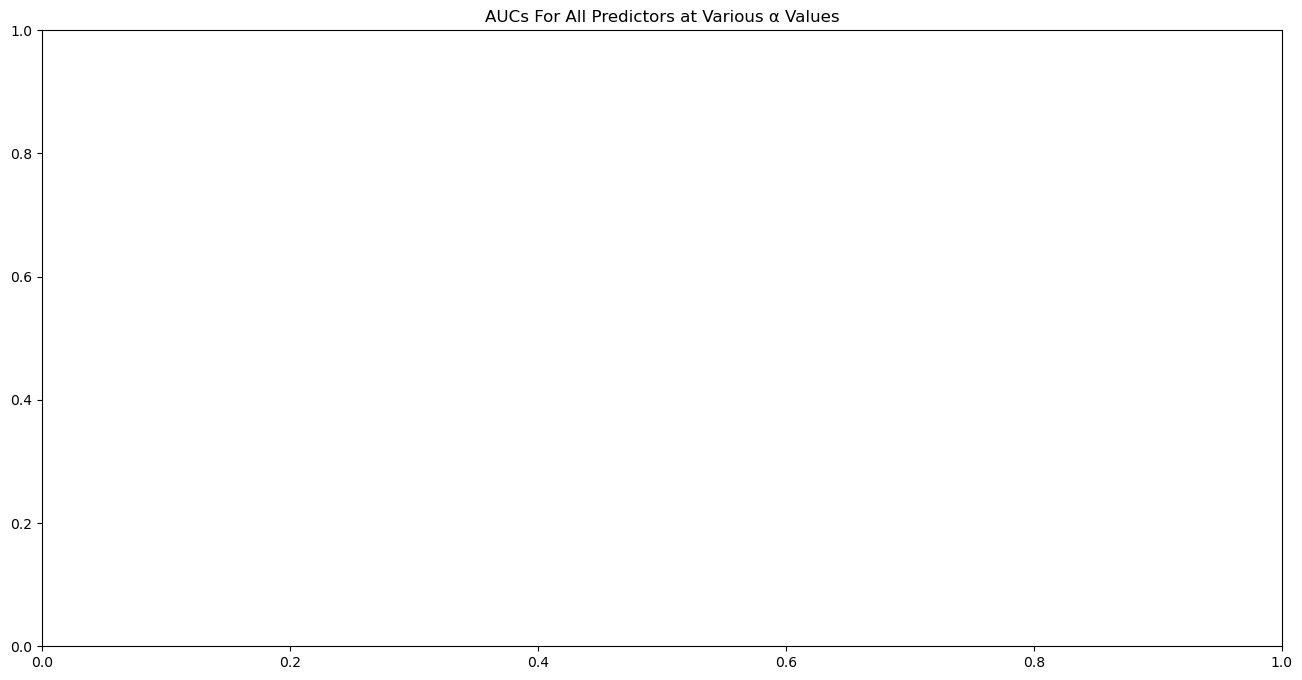

In [164]:
fig = plt.figure(figsize = (16, 8)) # This code is taken from the PS5 solutions and our own PS5
ax1 = fig.add_subplot(111)
plt.title("AUCs For All Predictors at Various \u03B1 Values")
plt.plot(alphas, AUCs_base, 'bo-', alpha = 0.5, label = 'Baseline')
plt.plot(alphas, AUCs_jacc, 'rs-', alpha = 0.5, label = 'Jaccard')
plt.plot(alphas, AUCs_degp, 'gv-', alpha = 0.5, label = 'Degree Product')
# plt.plot(alphas, AUCs_predOne, 'o1-', alpha = 0.5, label = 'New Predictor One')
# plt.plot(alphas, AUCs_predTwo, 'pD-', alpha = 0.5, label = 'New Predictor Two')
plt.legend(loc = "lower right")
plt.xlabel("\u03B1 Values")
plt.ylabel("AUCs")
plt.show()

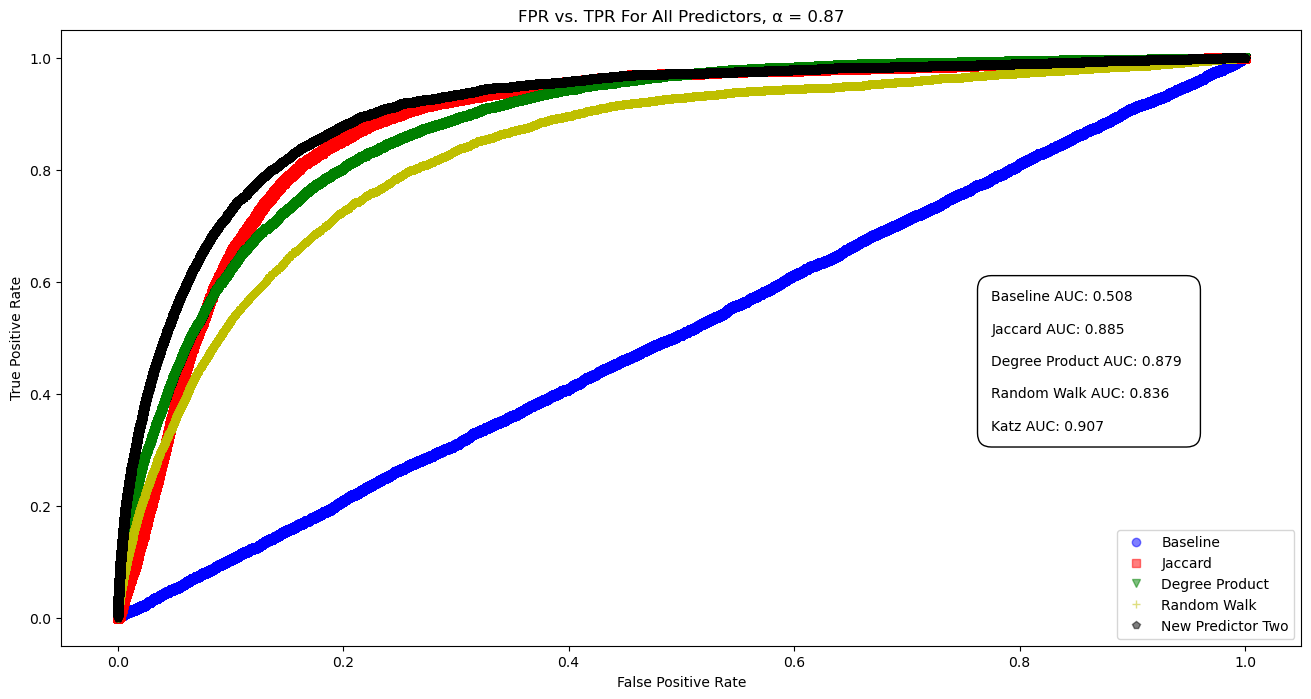

In [247]:
Go, missing = generateGo(G, .85) 
dist = randomwalk_DistributionGen(Go,5) # Generate distrubtion for random walk. 

table = apply_Predictors(Go, missing) 
columnOne = table[:, 0] # Here I am getting the columns of the table in the desired input format, this code was taken from our PS5 
columnTwo = table[:, 1] # We use the columns to create tables in the format needed for the tabulate_TPR_FPR and calculate_AUC function
columnThree = table[:, 2] # The first three columns are node i, node j, tau, in that order
columnFour = table[:, 3] # This column contains the baseline predictions
columnFive = table[:, 4] # This column contains the jaccard predictions
columnSix = table[:, 5] # This column contains the degree product predictions
columnSeven = table[:, 6] # This column contains the randomWalk predictions
columnEight = table[:, 7] # This column contains the katz predictions

columnOne = columnOne.reshape(len(columnOne), 1) # Reshaping columns, turning them into columns instead of horizontal lists
columnTwo = columnTwo.reshape(len(columnTwo), 1)
columnThree = columnThree.reshape(len(columnThree), 1)
columnFour = columnFour.reshape(len(columnFour), 1)
columnFive = columnFive.reshape(len(columnFive), 1)
columnSix = columnSix.reshape(len(columnSix), 1)
columnSeven = columnSeven.reshape(len(columnSeven), 1)
columnEight = columnEight.reshape(len(columnEight), 1)

baselineTable = np.hstack((columnOne, columnTwo)) # Here we are combining the columns of the table in the desired return format
baselineTable = np.hstack((baselineTable, columnThree))
baselineTable = np.hstack((baselineTable, columnFour))
baselineTable = baselineTable[np.argsort(baselineTable[:, 3])[::-1]] # Here we are sorting the table by the score column in descending order

jaccardTable = np.hstack((columnOne, columnTwo)) 
jaccardTable = np.hstack((jaccardTable, columnThree)) 
jaccardTable = np.hstack((jaccardTable, columnFive))
jaccardTable = jaccardTable[np.argsort(jaccardTable[:, 3])[::-1]]

degreeProductTable = np.hstack((columnOne, columnTwo)) 
degreeProductTable = np.hstack((degreeProductTable, columnThree))
degreeProductTable = np.hstack((degreeProductTable, columnSix))
degreeProductTable = degreeProductTable[np.argsort(degreeProductTable[:, 3])[::-1]]

randomWalkTable = np.hstack((columnOne, columnTwo)) 
randomWalkTable = np.hstack((randomWalkTable, columnThree))
randomWalkTable = np.hstack((randomWalkTable, columnSeven))
randomWalkTable = randomWalkTable[np.argsort(randomWalkTable[:, 3])[::-1]]

katzTable = np.hstack((columnOne, columnTwo)) 
katzTable = np.hstack((katzTable, columnThree))
katzTable = np.hstack((katzTable, columnEight))
katzTable = katzTable[np.argsort(katzTable[:, 3])[::-1]]

baselineTable = tabulate_TPR_FPR(baselineTable) # Here we are tabulating the tables and getting the TPR and FPR 
jaccardTable = tabulate_TPR_FPR(jaccardTable)
degreeProductTable = tabulate_TPR_FPR(degreeProductTable)
randomWalkTable = tabulate_TPR_FPR(randomWalkTable)
katzTable = tabulate_TPR_FPR(katzTable)

baselineAUC = calculate_AUC(baselineTable[:, 3], baselineTable[:, 4]) # Once we have tabulated the tables, we get the AUC for each predictor
jaccardAUC = calculate_AUC(jaccardTable[:, 3], jaccardTable[:, 4])
degreeProductAUC = calculate_AUC(degreeProductTable[:, 3], degreeProductTable[:, 4])
randomWalkAUC = calculate_AUC(randomWalkTable[:, 3], randomWalkTable[:, 4])
katzAUC = calculate_AUC(katzTable[:, 3], katzTable[:, 4])

text = "Baseline AUC: {:.3f} \n\nJaccard AUC: {:.3f} \n\nDegree Product AUC: {:.3f} \n\nRandom Walk AUC: {:.3f} \n\nKatz AUC: {:.3f}".format(baselineAUC, jaccardAUC, degreeProductAUC, randomWalkAUC, katzAUC)
fig = plt.figure(figsize = (16, 8)) # This code is taken from the PS5 solutions and our own PS5
ax1 = fig.add_subplot(111)
plt.title("FPR vs. TPR For All Predictors, \u03B1 = 0.87")
plt.plot(baselineTable[:,4], baselineTable[:,3], 'bo', alpha = 0.5, label = 'Baseline')
plt.plot(jaccardTable[:,4], jaccardTable[:,3], 'rs', alpha = 0.5, label = 'Jaccard')
plt.plot(degreeProductTable[:,4], degreeProductTable[:,3], 'gv', alpha = 0.5, label = 'Degree Product')
plt.plot(randomWalkTable[:,4], randomWalkTable[:,3], 'y+', alpha = 0.5, label = 'Random Walk')
plt.plot(katzTable[:,4], katzTable[:,3], 'kp', alpha = 0.5, label = 'Katz')
plt.annotate(text, xy = (0.75, 0.35), xycoords = "axes fraction", bbox = dict(facecolor = 'none', edgecolor = 'black', boxstyle = 'round, pad = 1'))
plt.legend(loc = "lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()